Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2

In [2]:
## Mounting Google Drive to read the Train and Test Data :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [67]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/ML_Data/Skin_cancer/Train/")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/ML_Data/Skin_cancer/Test/")

In [18]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [19]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [20]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

class_names = ['actinic keratosis','basal cell carcinoma','dermatofibroma','melanoma','nevus',
               'pigmented benign keratosis','seborrheic keratosis','squamous cell carcinoma','vascular lesion']
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,seed=123,labels="inferred",image_size=(img_height, img_width),
                            batch_size=batch_size,class_names=class_names,validation_split=0.2,subset="training")

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [21]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,seed=123,labels="inferred",image_size=(img_height, img_width),
                            batch_size=batch_size,class_names=class_names,validation_split=0.2,subset="validation")

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [22]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
num_classes = 9
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

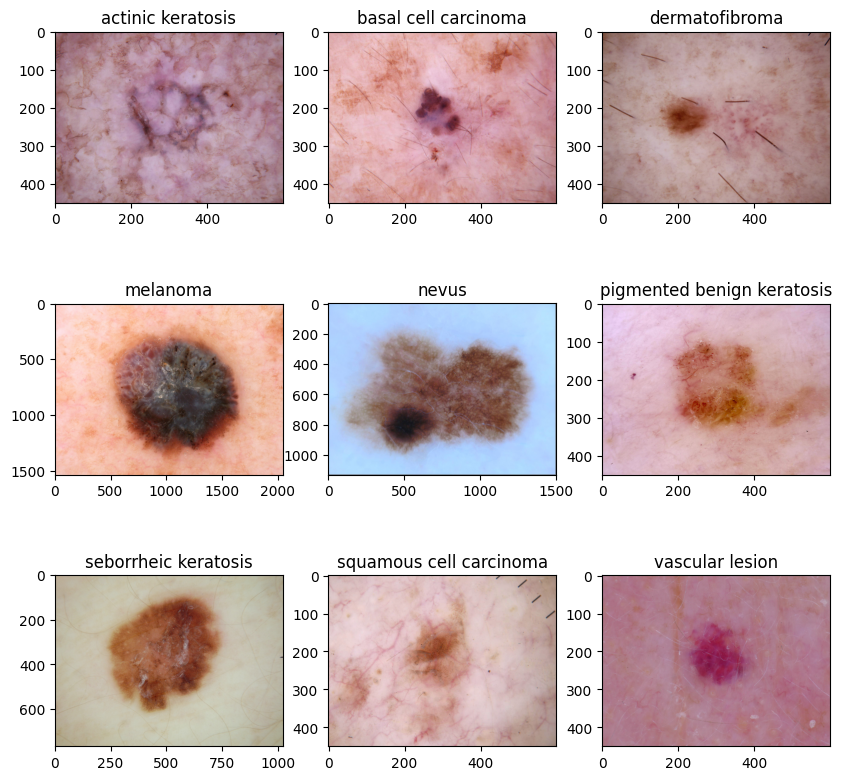

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  image = mpimg.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [26]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [27]:
#Standardize the values
model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(num_classes,activation = "softmax"))


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [28]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      18464     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 32)        18464     
                                                        

### Train the model

In [30]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 661s 2s/step - loss: 2.0712 - accuracy: 0.1908 - val_loss: 1.9621 - val_accuracy: 0.2550
Epoch 2/20
56/56 [==============================] - 5s 85ms/step - loss: 2.0345 - accuracy: 0.2109 - val_loss: 1.9731 - val_accuracy: 0.1946
Epoch 3/20
56/56 [==============================] - 5s 90ms/step - loss: 2.0119 - accuracy: 0.2048 - val_loss: 2.0182 - val_accuracy: 0.2081
Epoch 4/20
56/56 [==============================] - 5s 90ms/step - loss: 1.9671 - accuracy: 0.2478 - val_loss: 1.8842 - val_accuracy: 0.3512
Epoch 5/20
56/56 [==============================] - 5s 85ms/step - loss: 1.8269 - accuracy: 0.3281 - val_loss: 1.9907 - val_accuracy: 0.2998
Epoch 6/20
56/56 [==============================] - 5s 83ms/step - loss: 1.8904 - accuracy: 0.3025 - val_loss: 1.8498 - val_accuracy: 0.3758
Epoch 7/20
56/56 [==============================] - 5s 89ms/step - loss: 1.8040 - accuracy: 0.3359 - val_loss: 1.9105 - val_accuracy: 0.3244
Epoch 8/20
56/56 [======

### Visualizing training results

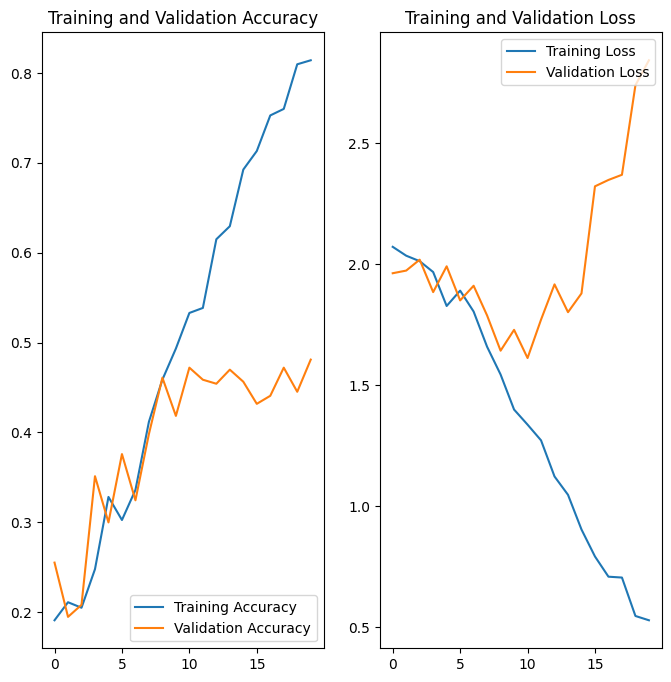

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit


#### Findings: The model is Overfit as the training accuracy is significantly higher than Test accuracy

In [32]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.

data_aug = tf.keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.3, fill_mode='nearest'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

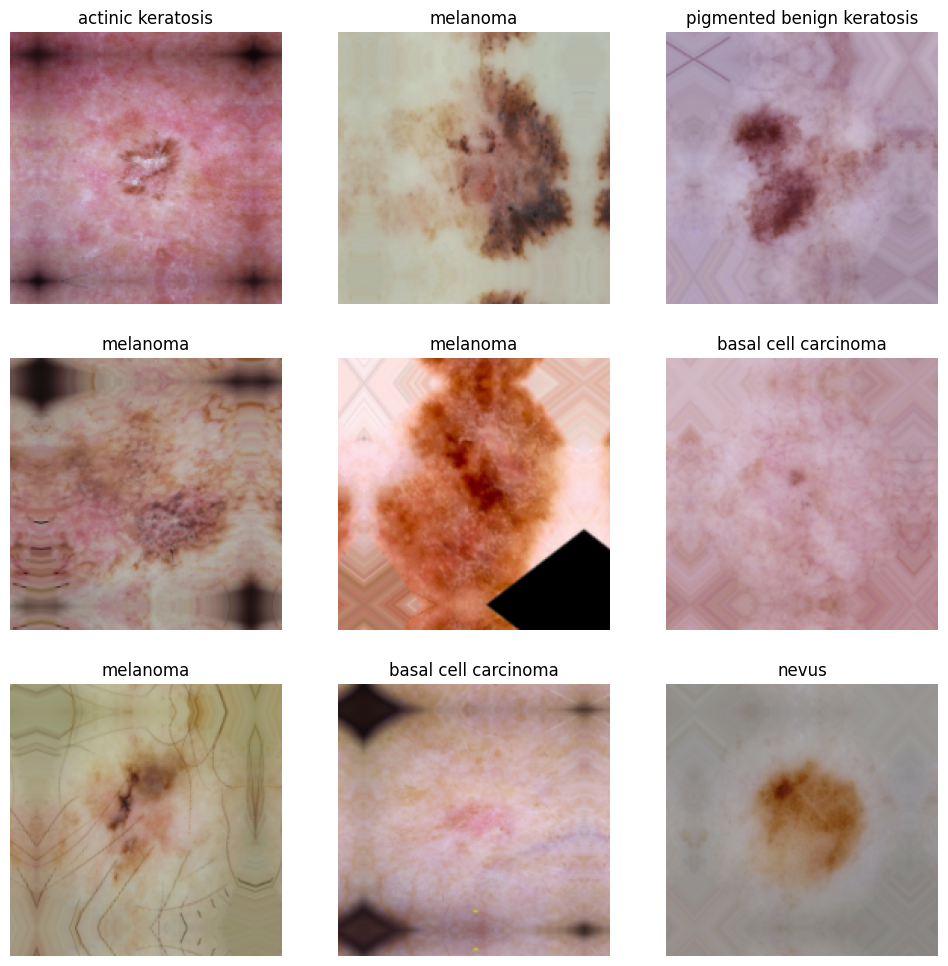

In [33]:
# Todo, visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_aug(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [41]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
## Used dropout layer

model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation = "softmax"))



### Compiling the model

In [42]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [43]:
# View the summary of all layers
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 64)      1792      
                                                                 
 conv2d_16 (Conv2D)          (None, 180, 180, 32)      18464     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 90, 90, 64)        18496     
                                                      

### Training the model

In [44]:
## Your code goes here, note: train your model for 20 epochs

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 9s 121ms/step - loss: 2.0586 - accuracy: 0.1920 - val_loss: 2.0773 - val_accuracy: 0.1521
Epoch 2/20
56/56 [==============================] - 7s 117ms/step - loss: 2.0266 - accuracy: 0.2165 - val_loss: 2.0199 - val_accuracy: 0.1946
Epoch 3/20
56/56 [==============================] - 7s 117ms/step - loss: 2.0207 - accuracy: 0.2143 - val_loss: 2.0242 - val_accuracy: 0.1991
Epoch 4/20
56/56 [==============================] - 7s 116ms/step - loss: 1.9822 - accuracy: 0.2433 - val_loss: 1.9402 - val_accuracy: 0.2617
Epoch 5/20
56/56 [==============================] - 6s 115ms/step - loss: 1.8174 - accuracy: 0.3532 - val_loss: 1.6584 - val_accuracy: 0.4206
Epoch 6/20
56/56 [==============================] - 7s 120ms/step - loss: 1.6049 - accuracy: 0.4353 - val_loss: 1.4805 - val_accuracy: 0.4944
Epoch 7/20
56/56 [==============================] - 6s 114ms/step - loss: 1.4653 - accuracy: 0.4805 - val_loss: 1.4974 - val_accuracy: 0.4922
Epoch 

### Visualizing the results

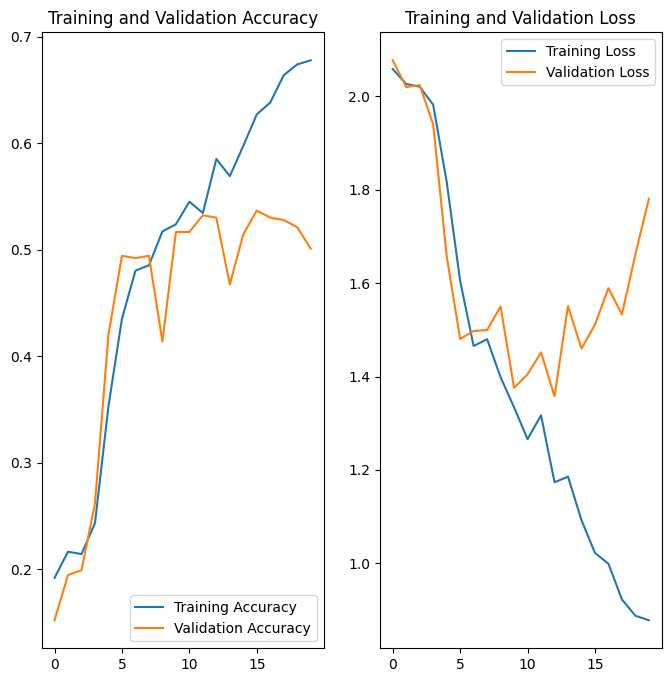

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### Findings: There is a little bit improvement, Model is still overfit but not like iteration #1

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [46]:

class_size = {}

for name in class_names:
    class_size[name] = len(list(data_dir_train.glob(name+'/*.jpg')))

class_size


{'actinic keratosis': 114,
 'basal cell carcinoma': 376,
 'dermatofibroma': 95,
 'melanoma': 438,
 'nevus': 357,
 'pigmented benign keratosis': 462,
 'seborrheic keratosis': 77,
 'squamous cell carcinoma': 181,
 'vascular lesion': 139}

In [47]:
class_df = pd.DataFrame(class_size.items(),index=list(class_size), columns = ['ClassName', 'Number_Of_Samples'])
class_df[['ClassName', 'Number_Of_Samples']]

,ClassName,Number_Of_Samples
actinic keratosis,actinic keratosis,114
basal cell carcinoma,basal cell carcinoma,376
dermatofibroma,dermatofibroma,95
melanoma,melanoma,438
nevus,nevus,357
pigmented benign keratosis,pigmented benign keratosis,462
seborrheic keratosis,seborrheic keratosis,77
squamous cell carcinoma,squamous cell carcinoma,181
vascular lesion,vascular lesion,139


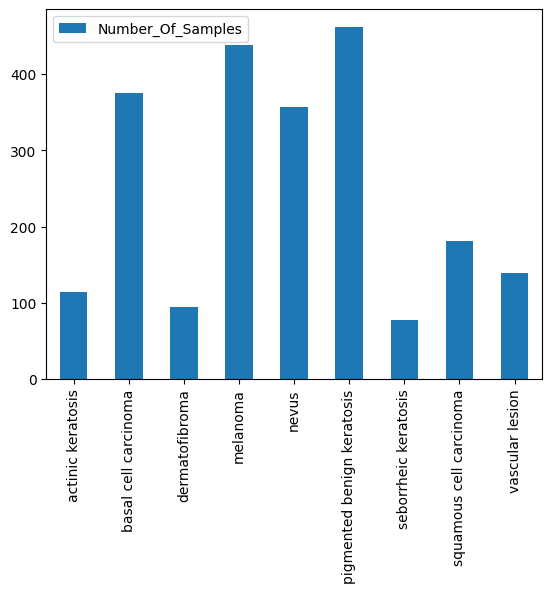

In [48]:
class_df.plot.bar()
plt.show()

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [49]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [52]:
# ** Might need to add class specific augmentation

#class_names_aug= ['actinic keratosis','dermatofibroma','seborrheic keratosis','squamous cell carcinoma','vascular lesion']
path_to_training_dataset="/content/gdrive/My Drive/ML_Data/Skin_cancer/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/ML_Data/Skin_cancer/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1FF8B67B80>: 100%|██████████| 500/500 [00:22<00:00, 22.06 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/ML_Data/Skin_cancer/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1FF8D72A40>: 100%|██████████| 500/500 [00:21<00:00, 22.93 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/ML_Data/Skin_cancer/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F20A57EEF20>: 100%|██████████| 500/500 [00:21<00:00, 23.43 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/ML_Data/Skin_cancer/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F1FF8D70580>: 100%|██████████| 500/500 [01:39<00:00,  5.00 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/ML_Data/Skin_cancer/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F1FF8C62A70>: 100%|██████████| 500/500 [01:55<00:00,  4.32 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/ML_Data/Skin_cancer/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1FF8C637F0>: 100%|██████████| 500/500 [00:22<00:00, 22.18 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/ML_Data/Skin_cancer/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F20A558FB80>: 100%|██████████| 500/500 [00:51<00:00,  9.70 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/ML_Data/Skin_cancer/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F20A5792A40>: 100%|██████████| 500/500 [00:23<00:00, 21.19 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/ML_Data/Skin_cancer/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1FF8D70550>: 100%|██████████| 500/500 [00:27<00:00, 17.86 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [53]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [57]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#path_list_new


In [58]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#lesion_list_new

In [59]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [61]:
original_df = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/ML_Data/Skin_cancer/Tr...,actinic keratosis
1,/content/gdrive/MyDrive/ML_Data/Skin_cancer/Tr...,actinic keratosis
2,/content/gdrive/MyDrive/ML_Data/Skin_cancer/Tr...,actinic keratosis
3,/content/gdrive/MyDrive/ML_Data/Skin_cancer/Tr...,actinic keratosis
4,/content/gdrive/MyDrive/ML_Data/Skin_cancer/Tr...,actinic keratosis
...,...,...
4495,/content/gdrive/MyDrive/ML_Data/Skin_cancer/Tr...,vascular lesion
4496,/content/gdrive/MyDrive/ML_Data/Skin_cancer/Tr...,vascular lesion
4497,/content/gdrive/MyDrive/ML_Data/Skin_cancer/Tr...,vascular lesion
4498,/content/gdrive/MyDrive/ML_Data/Skin_cancer/Tr...,vascular lesion


In [62]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-62-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [63]:
new_df['Label'].value_counts()

actinic keratosis             1000
basal cell carcinoma          1000
dermatofibroma                1000
melanoma                      1000
nevus                         1000
pigmented benign keratosis    1000
seborrheic keratosis          1000
squamous cell carcinoma       1000
vascular lesion               1000
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [64]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [68]:
#data_dir_train="path to directory with training data + data created using augmentor"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [69]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [70]:
## Added Normalization
model = Sequential([data_aug,layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Dense(num_classes, activation = "softmax"))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [71]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [72]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 [==============================] - 48s 249ms/step - loss: 2.6873 - accuracy: 0.3329 - val_loss: 3.3352 - val_accuracy: 0.1403
Epoch 2/50
169/169 [==============================] - 45s 259ms/step - loss: 1.8284 - accuracy: 0.4056 - val_loss: 2.6911 - val_accuracy: 0.1359
Epoch 3/50
169/169 [==============================] - 43s 246ms/step - loss: 1.5625 - accuracy: 0.4394 - val_loss: 2.5361 - val_accuracy: 0.2056
Epoch 4/50
169/169 [==============================] - 44s 256ms/step - loss: 1.4722 - accuracy: 0.4662 - val_loss: 1.7457 - val_accuracy: 0.3460
Epoch 5/50
169/169 [==============================] - 43s 246ms/step - loss: 1.3359 - accuracy: 0.5013 - val_loss: 1.6648 - val_accuracy: 0.3964
Epoch 6/50
169/169 [==============================] - 45s 260ms/step - loss: 1.3213 - accuracy: 0.5061 - val_loss: 1.4656 - val_accuracy: 0.4610
Epoch 7/50
169/169 [==============================] - 44s 252ms/step - loss: 1.2564 - accuracy: 0.5111 - val_loss: 1.2776 - val_accuracy: 0.5

#### **Todo:**  Visualize the model results

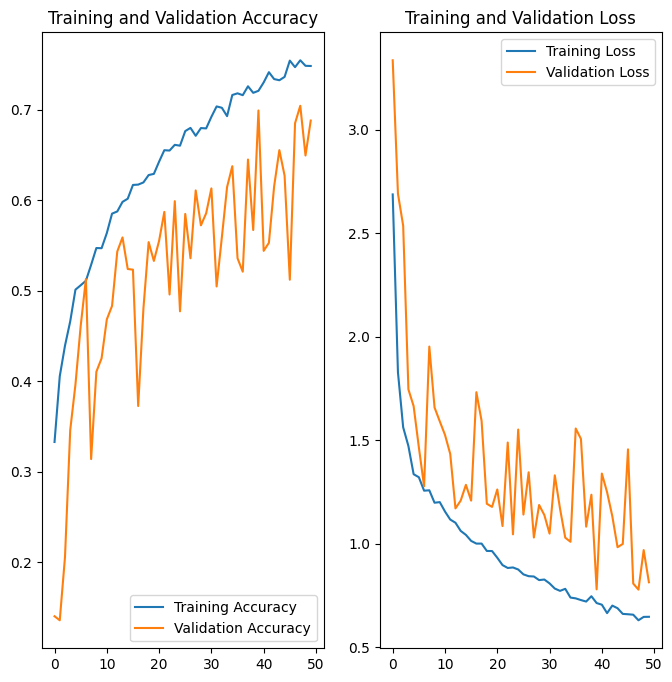

In [73]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Findings: Based on the Accuracy and loss, the model is now not overfitting or underfitting. The class rebalance did help.  

In [75]:
model.save("/content/gdrive/MyDrive/ML_Data/Skin_cancer/model.h5")